In [40]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [41]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img import images
from my_libs.img.camshift import *
from my_libs.img.processing import *
from my_libs.img.camshift import CamShift

In [42]:
ml.tools.printf("Hello world!")

Hello world!

# Cvičení 10

In [43]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os

1)  Segmentujte video (`pvi_cv10_video_in.mp4`) libovolným  funkčním segmentačním algoritmem.  
 
2)  V  každém  video  segmentu  detekujte  pohybující  se  objekty  pomocí algoritmu  CamShift  nebo  Background  Subtraction.  Detekované  objekty označte ve  snímcích obdélníkem. 
 
3) Naprogramujte vlastní algoritmy pro segmentaci, Background Subtraction a  CamShift.  Pro  CamShift  můžete  použít  vzor (`pvi_cv10_vzor_pomeranc.bmp`). 
 
4) Výsledné snímky (s  detekcí) poskládejte do nového video souboru se snímkovací frekvencí 10 snímků/s. 
 
help: 
```python
cap = cv2.VideoCapture('pvi_cv10_video_in.mp4') 

while True: 
    ret, bgr = cap.read() 

out = cv2.VideoWriter(... 
out.write(bgr) 
```

In [44]:
folder = 'data/'
video_file = "pvi_cv10_video_in.mp4"
template_file = "pvi_cv10_vzor_pomeranc.bmp"

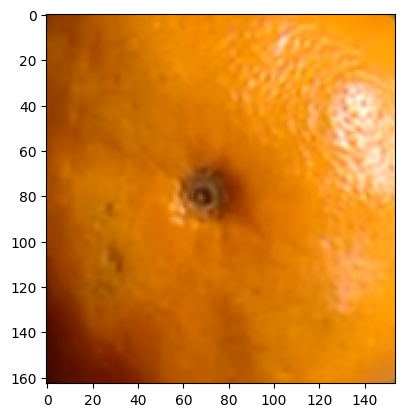

In [45]:
# load template
template = cv.imread(folder + template_file)
template = cv.cvtColor(template, cv.COLOR_BGR2RGB)

# show template
plt.imshow(template)
plt.show()

In [46]:
from IPython.display import display, Image

video = cv.VideoCapture(folder + video_path)
display_handle=display(None, display_id=True)
try:
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        _, frame = cv.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

## Detekce typu snímků

mp4 video obsahuje 3 typy snímků:
- I snímky (klíčové snímky) - obsahují kompletní informaci o scéně
- P snímky (predikované snímky) - obsahují informaci o změnách oproti předchozímu snímku
- B snímky (bi-predikované snímky) - obsahují informaci o změnách oproti předchozímu a následujícímu snímku

In [47]:
import subprocess

def get_frame_types(video_file):
    result = subprocess.run(
        ['ffprobe', '-select_streams', 'v', '-show_frames', '-show_entries', 'frame=pict_type', '-of', 'csv', video_file],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )
    frame_types = result.stdout.splitlines()
    return frame_types

video_path = folder + video_file
frame_types = get_frame_types(video_path)

print("Number of frames:", len(frame_types))

# Example usage
I_frames = []
frame_number = 0
for frame_type in frame_types:
    frame_number += 1
    if 'I' in frame_type:
        I_frames.append(frame_number)
        print(f'Frame {frame_number} is I-frame')
    elif 'P' in frame_type:
        #print(f'Frame {frame_number} is P-frame')
        pass
    elif 'B' in frame_type:
        #print(f'Frame {frame_number} is B-frame')
        pass

Number of frames: 272
Frame 1 is I-frame
Frame 72 is I-frame
Frame 202 is I-frame


## CamShift

In [ ]:
def process_image(image):
    """ Process image
    """
    bgr = cv2.imread(image)

    # Plot
    plt.figure()
    plt.subplot(1, 3, 1)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)

    plt.subplot(1, 3, 2)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    plt.imshow(hsv)

    plt.subplot(1, 3, 3)
    hist = img2hue_histogram(bgr)
    plt.plot(hist)
    plt.title("Histogram")
    plt.xlabel("Hue")
    plt.ylabel("Count")

    plt.show()

    # picure size
    print("Image size: {0}".format(rgb.shape))

    plt.waitforbuttonpress()

In [49]:
plt.ion()
clear()
plt.close('all')

In [53]:
camshift = CamShift(folder + template_file)

"""
cap = cv.VideoCapture(folder + video_file)
patern_bgr = cv.imread(pattern_file)
pattern_hue_hist = img2hue_histogram(patern_bgr)
hsv = cv.cvtColor(bgr, cv.COLOR_BGR2HSV)
hue = hsv[:,:,0]

# img projection
hue_projection = pattern_hue_hist[hue]
cv.rectangle(hue_projection, (x1, y1), (x2, y2), (255, 255, 255))
cv.imshow('Image', hue_projection)
"""

# Zkontrolujte, zda soubor existuje
video_path = folder + video_file
if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

# Pokus o otevření videa
video = cv.VideoCapture(video_path)
if not video.isOpened():
    raise IOError(f"Cannot open video file: {video_path}")


display_handle=display(None, display_id=True)
frame_number = 0
try:
    while(video.isOpened()):
        ret, frame = video.read()
        if not ret:
            break
        
        frame_number += 1
        if frame_number > I_frames[1] and frame_number < I_frames[2]:
            (x1, y1), (x2, y2) = camshift.next_positon(frame)

            cv.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0))
        
        _, frame = cv.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

print("Done")      


None

Done
